# Статистические модели прогнозирования. Практика

Задача - проанализировать ВВП африканской страны Гана.

Прочитаем исходный файл с данными:

In [57]:
import pandas as pd

data = pd.read_csv("/content/ghana_gdp.csv", parse_dates=["year"], index_col=["year"])
data.info

<bound method DataFrame.info of             GDP (current US$)
year                         
1960-01-01       1.217087e+09
1961-01-01       0.000000e+00
1962-01-01       1.382353e+09
1963-01-01       1.540616e+09
1964-01-01       1.731092e+09
...                       ...
2017-01-01       6.040638e+10
2018-01-01       6.729928e+10
2019-01-01       6.833754e+10
2020-01-01       7.004320e+10
2021-01-01       7.759428e+10

[62 rows x 1 columns]>

Визуализируем исходный временной ряд:

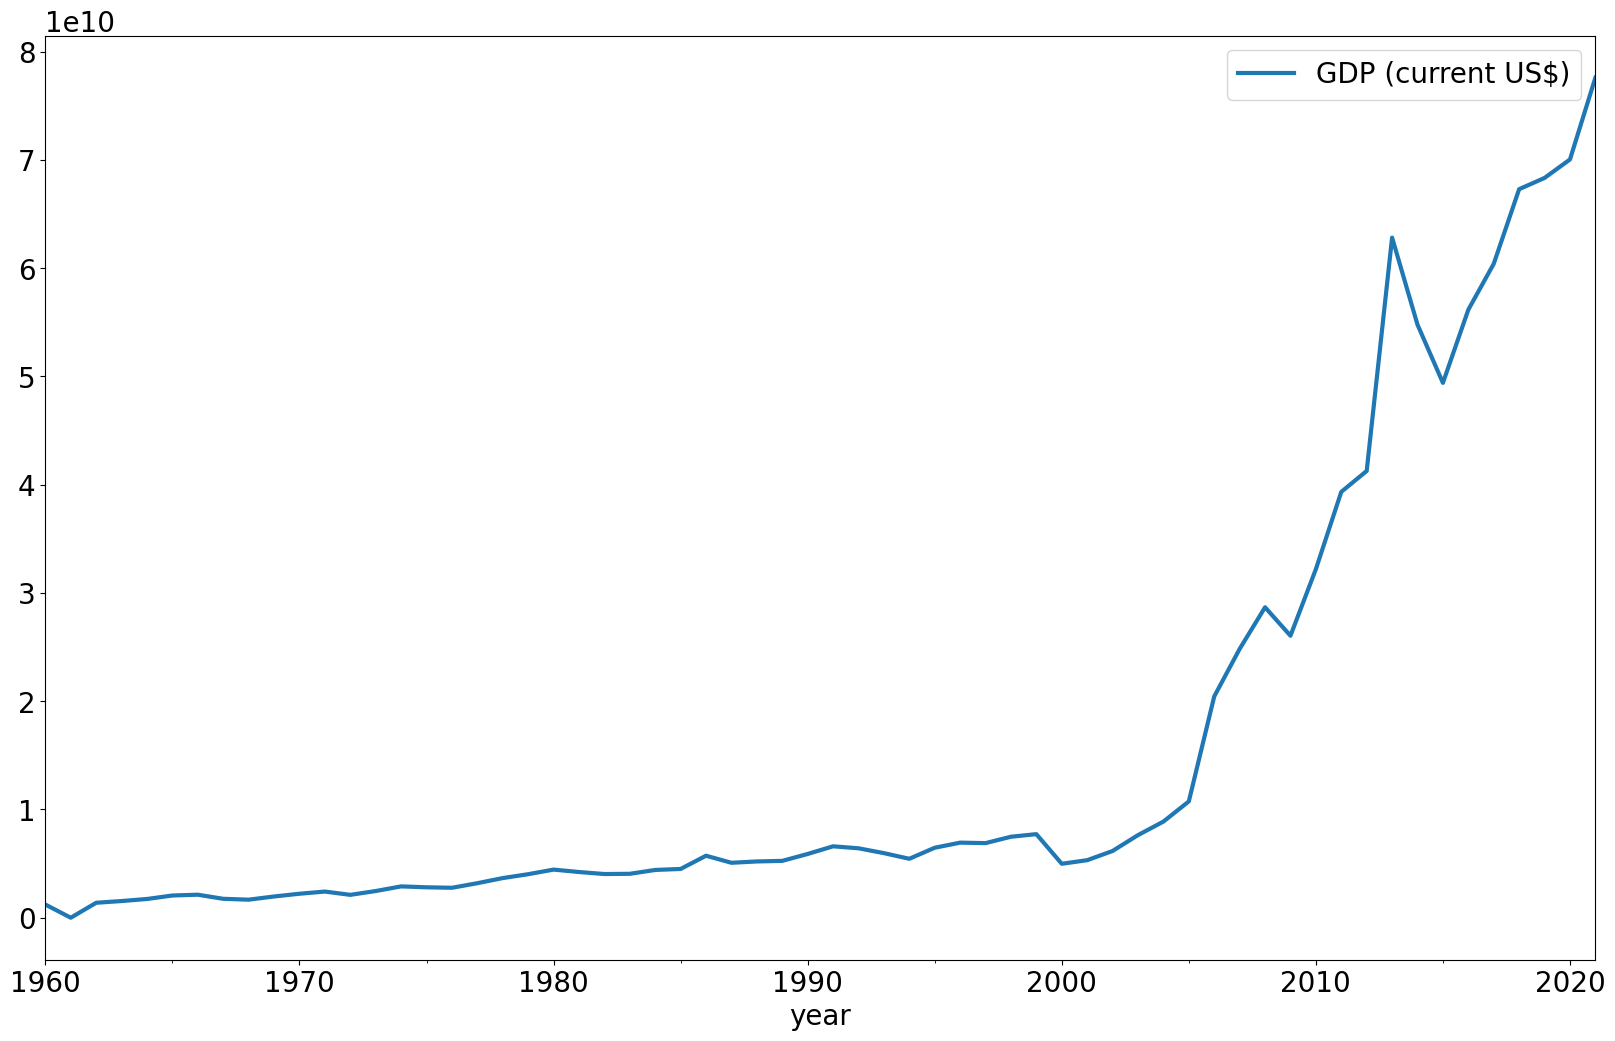

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = 20, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()

In [3]:
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

Сделаем декомпозицию временного ряда:

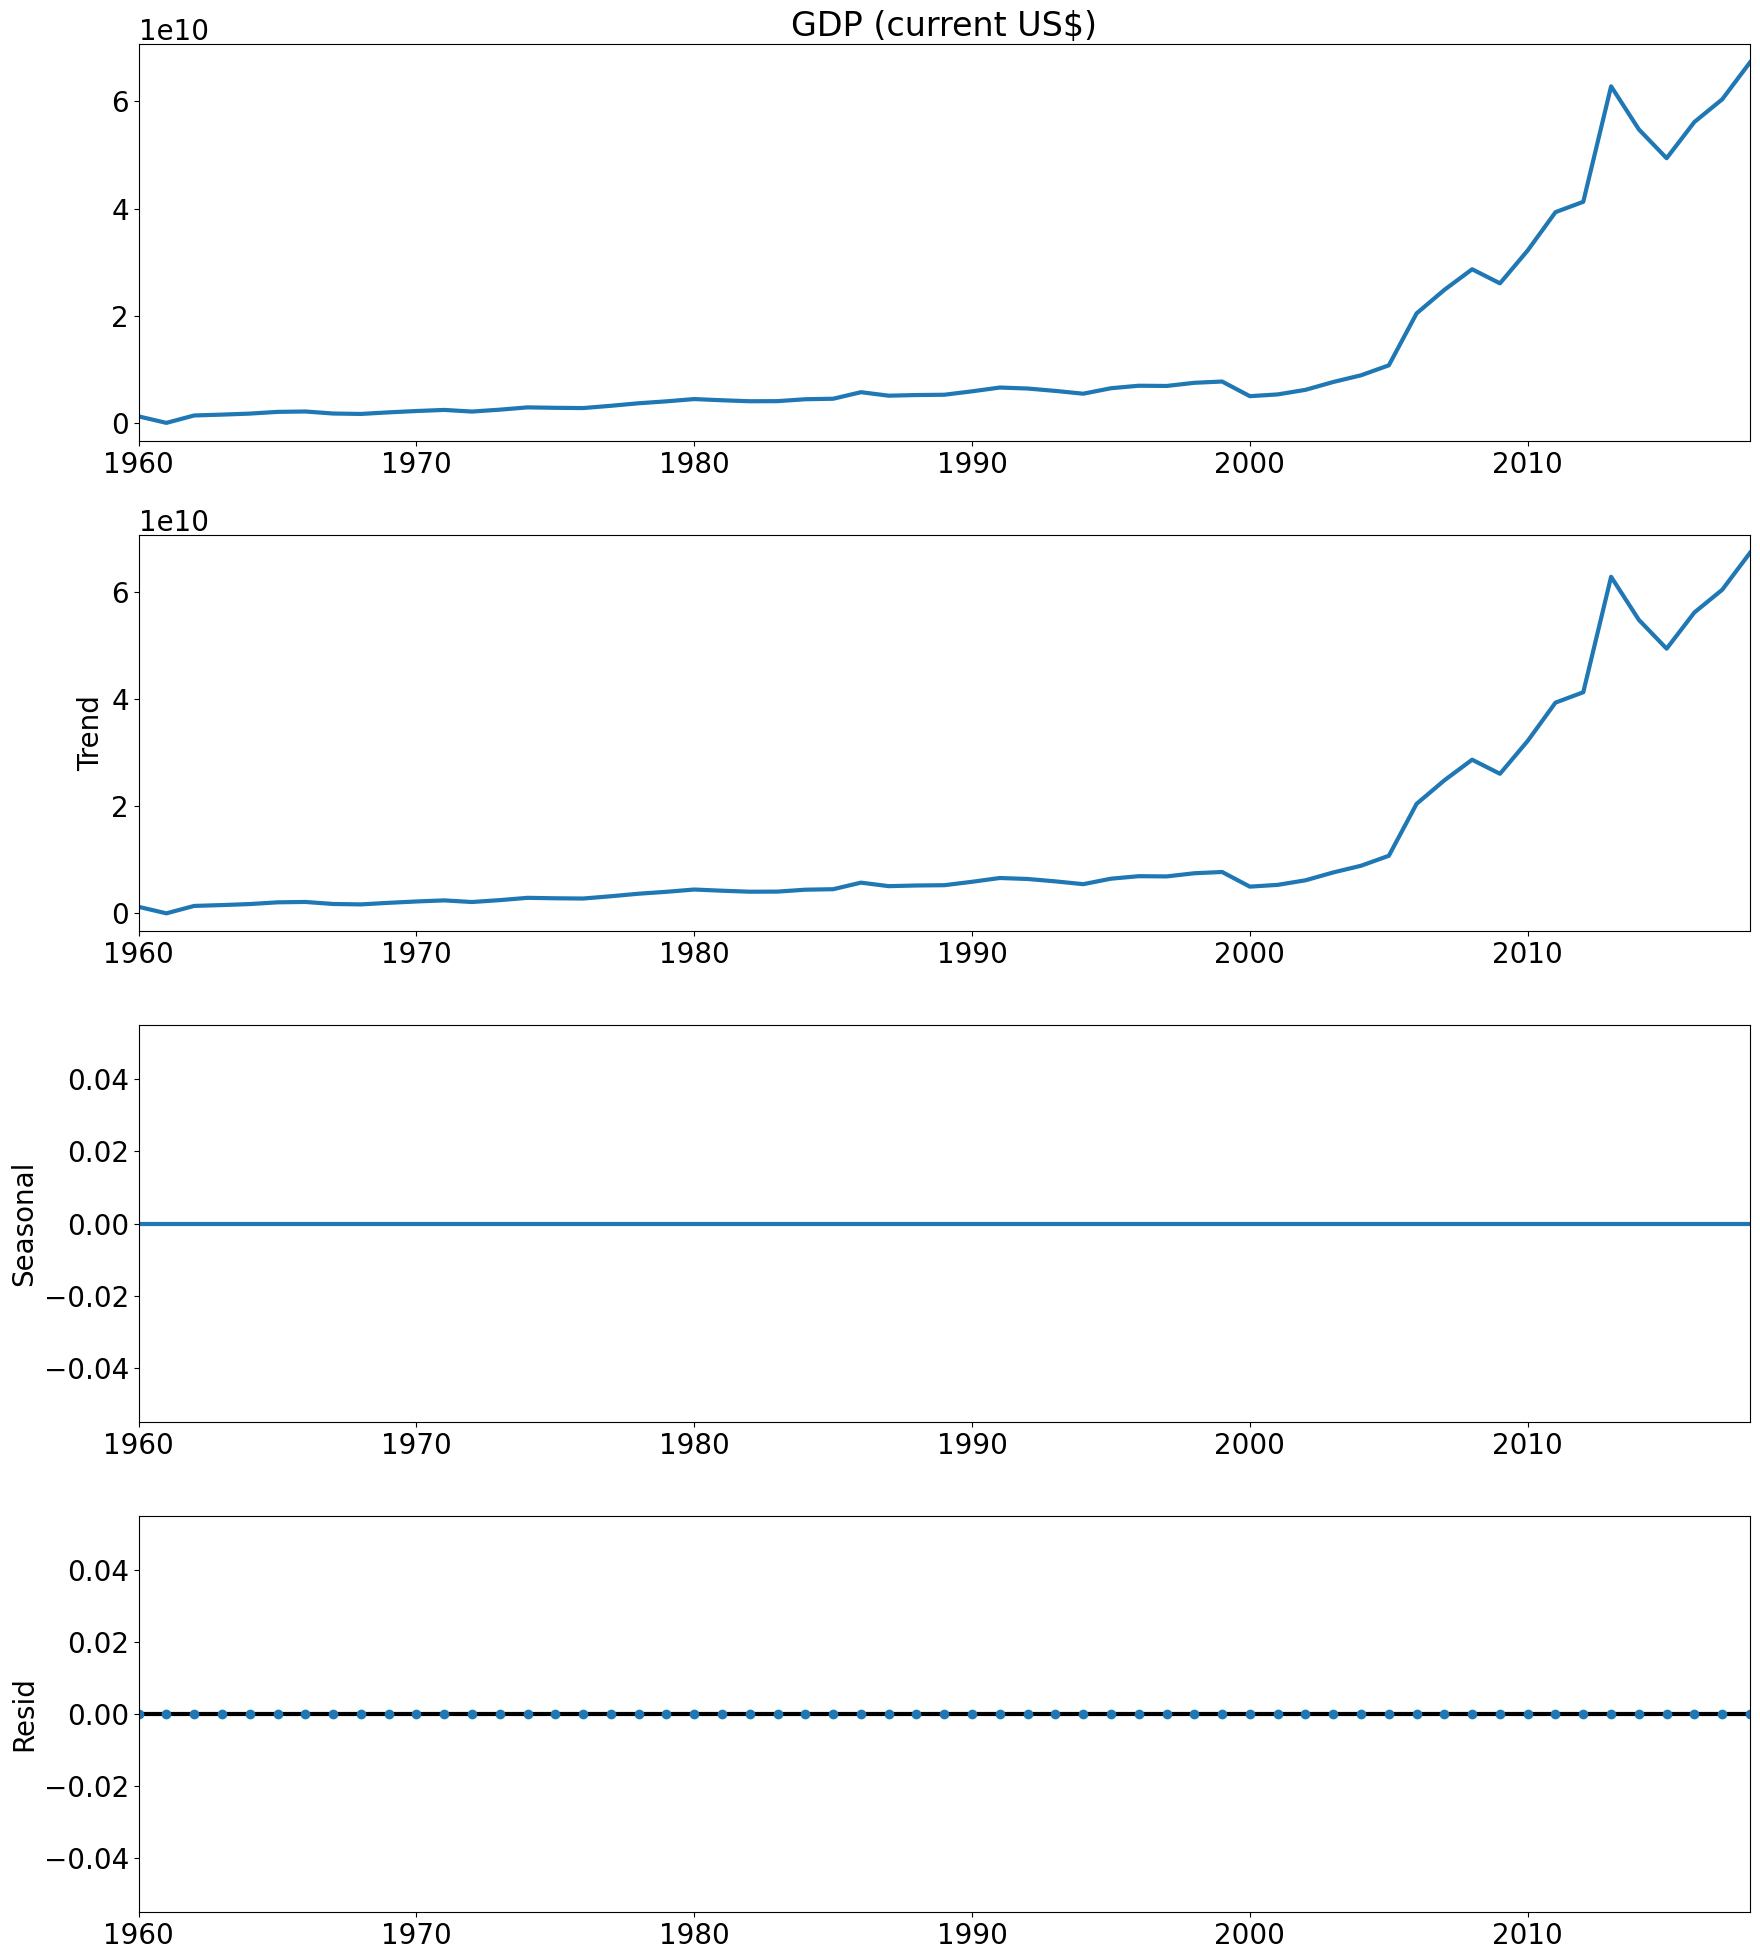

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df['GDP (current US$)'])
result.plot()
plt.show()

Сезонная компонента и дисперсия равна нулю, график тренда повторяет график исходного ряда.

Визуализируем исходный временной ряд и построенный с помощью скользящего среднего:

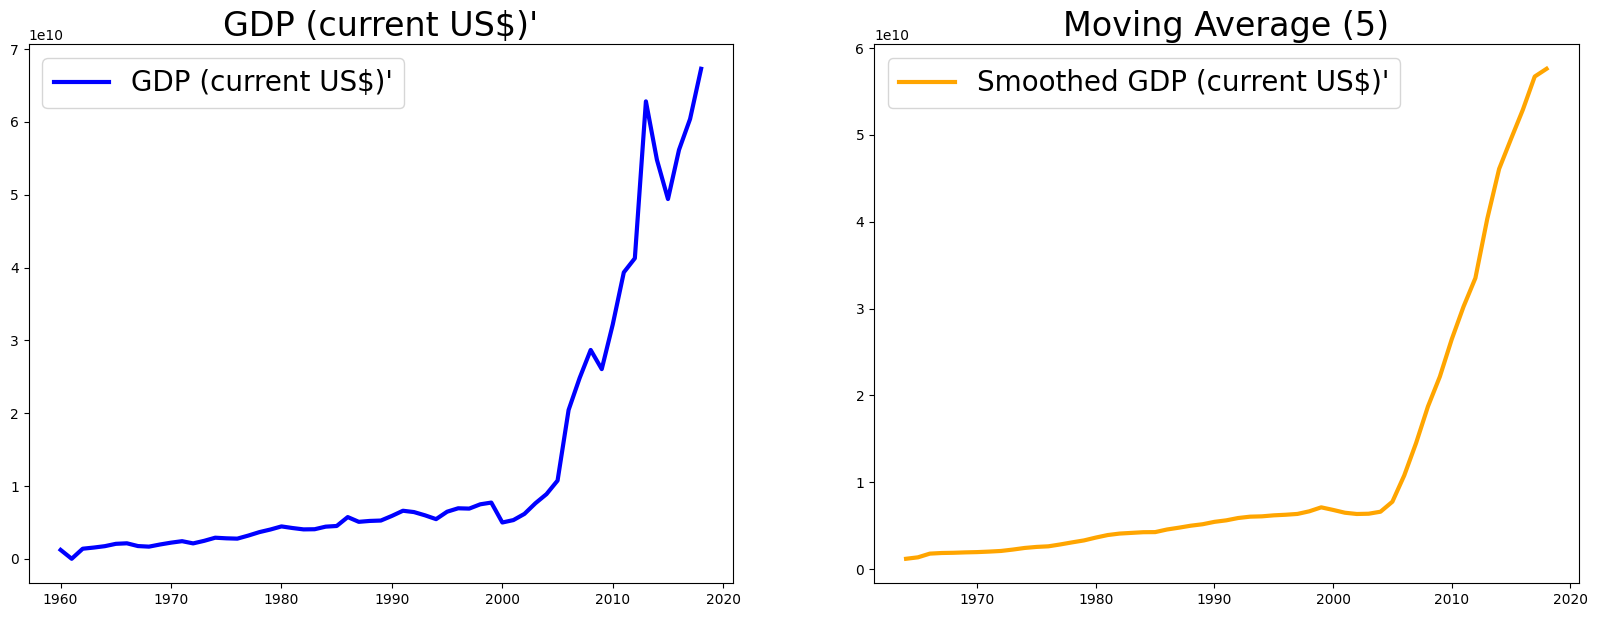

In [86]:
plt.rcParams["figure.figsize"] = 20, 7

fig, ax = plt.subplots(1, 2)


ax[0].plot(train_df['GDP (current US$)'], color="blue", label="GDP (current US$)'")
ax[0].set_title("GDP (current US$)'", size=24)
ax[0].legend()

ax[1].plot(
    train_df['GDP (current US$)'].rolling(window=5).mean(),
    color="orange",
    label="Smoothed GDP (current US$)'",
)

ax[1].set_title("Moving Average (5)", size=24)
ax[1].legend()



# ax[1, 0].plot(train_df['GDP (current US$)'], color="blue", label="GDP (current US$)'")
# ax[1, 0].set_title("GDP (current US$)'", size=24)
# ax[1, 0].legend()

# ax[1, 1].plot(
#     train_df['GDP (current US$)'].rolling(window=5).mean(),
#     color="orange",
#     label="Smoothed GDP (current US$)'",
# )

# ax[1, 1].set_title("Moving Average (5)", size=24)
# ax[1, 1].legend()

plt.show()

Еще раз убеждаемся, что тренд положительный с увеличением темпа роста после 2005 года. Графики рядов, построенные с помощью скользящего среднего похожи на график исходного ряда.

Автокорреляция:

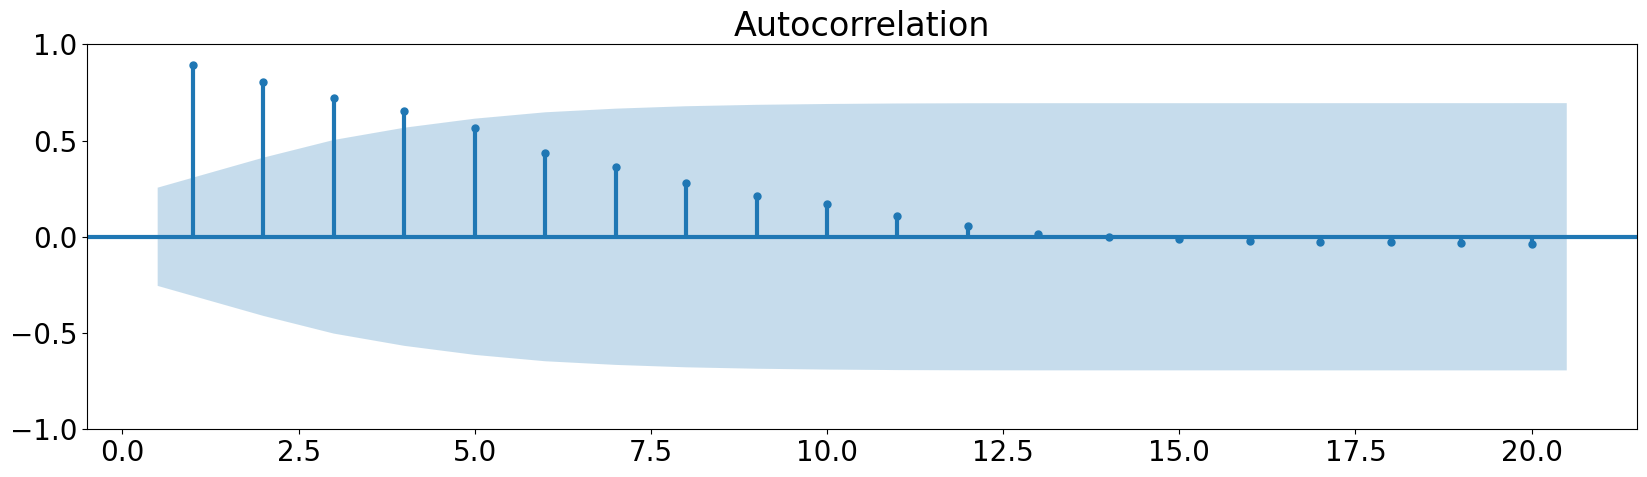

In [58]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df['GDP (current US$)'], lags=20, zero=False)
plt.show()

Корреляция сохраняется до 12 лага.

Частичная автокорреляция:

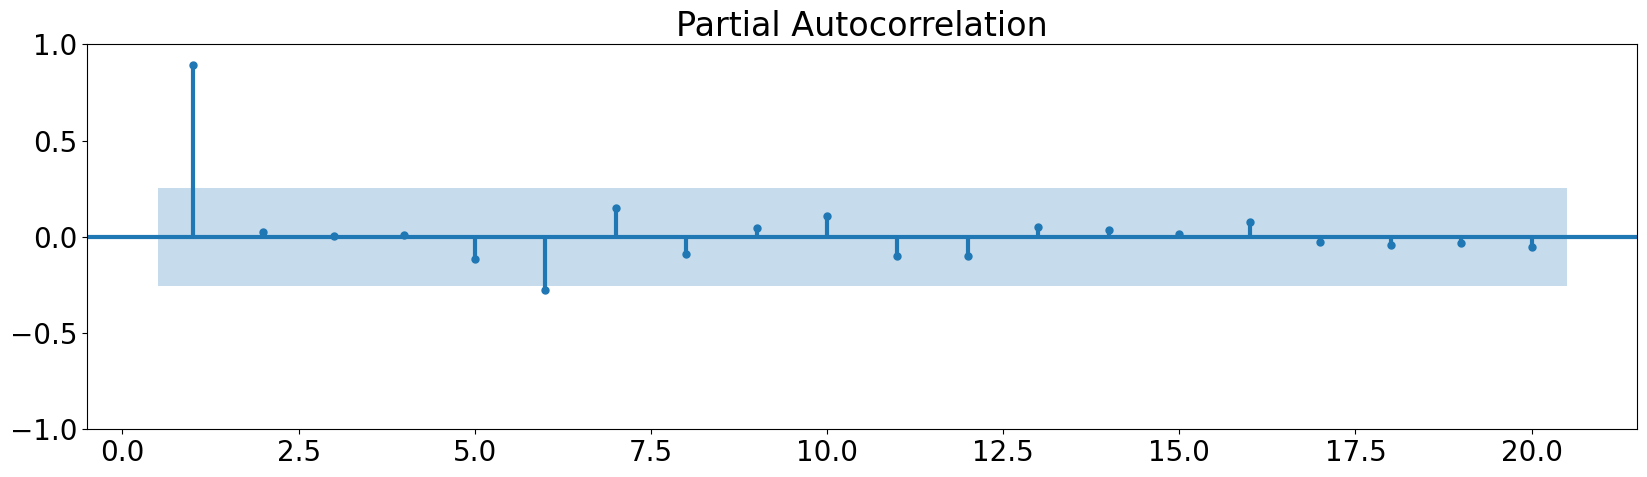

In [59]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df['GDP (current US$)'], lags=20, method="ywm", zero=False)
plt.show()

В отличие от того, что предлагали графики ACF,  уровень GDP с лагом не приносят никакой новой информации. В таких ситуация параметр p выбирается = 1.

Проведем тест на стационарность:

In [68]:
from statsmodels.tsa.stattools import adfuller

def df_test(data):
    test_1 = adfuller(data)
    print("adf: ", test_1[0])
    print("p-value: ", test_1[1])
    print("Critical values: ", test_1[4])
    if test_1[0] > test_1[4]["5%"]:
        print("Ряд нестационарен")
    else:
        print("Ряд стационарен")

df_test(train_df['GDP (current US$)'])


adf:  0.6529066974885405
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Ряд нестационарен


## Дифференцирование ряда
$y\_new_t = y_t - y_{t-1}$

where,
- $y\_new_t$: Дифференцированное значение ряда $t$
- $y_t$: Фактическое значение ряда $t$
- $y_{t-1}$: Фактическое значение ряда $t-1$

In [70]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=12)
    sgt.plot_pacf(series, ax=axes[1], lags=12, method="ywm")
    plt.show()

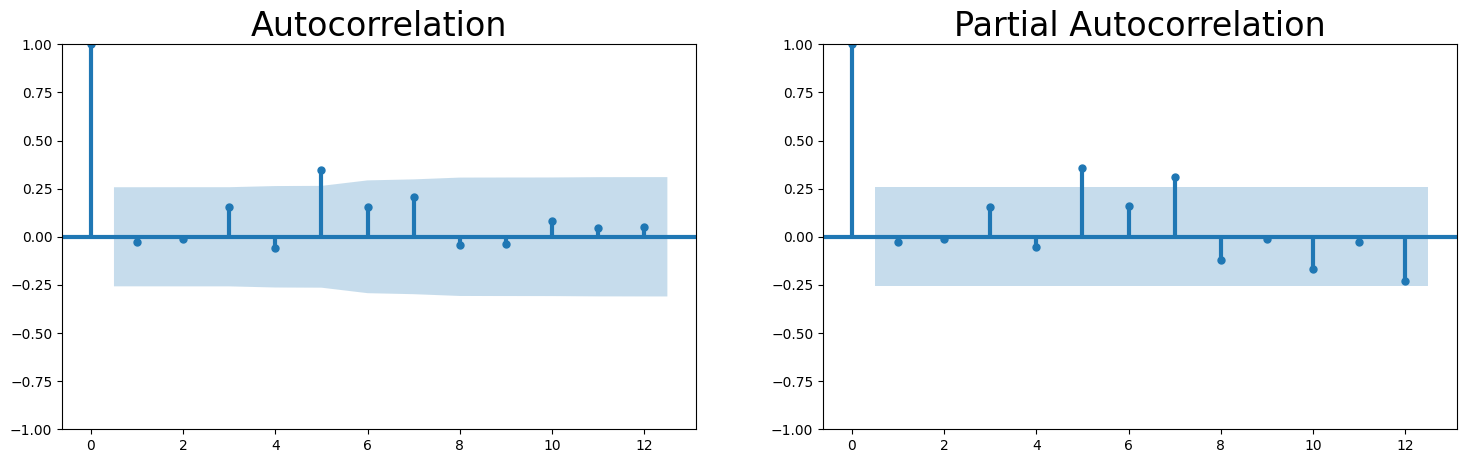

adf:  -1.670248303832082
p-value:  0.44650293297138693
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
Ряд нестационарен


In [71]:
plot_acf_pacf(train_df['GDP (current US$)'].diff().dropna())

diff_1 = train_df['GDP (current US$)'].diff().dropna()

df_test(diff_1)

Принимаем p и q = 1.

Первые разности являются нестационарными

In [12]:
diff_2 = diff_1.diff().dropna()

df_test(diff_2)

adf:  -2.6408690561284924
p-value:  0.08484116917837625
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
Ряд нестационарен


Разности второго порядка являются нестационарными

In [13]:
diff_3 = diff_2.diff().dropna()

df_test(diff_3)

adf:  -4.779623784828569
p-value:  5.948327640223947e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Ряд стационарен


Разности третьего порядка уже являются стационарными, принимем d = 3.

**PMDARIMA**

Начнем построение модели **PMDARIMA**:

In [72]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=12,
    max_q=3,
    D=1,
    start_P=0,
    # seasonal=False,
    m=50,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,1,1)[50]             : AIC=inf, Time=3.96 sec
 ARIMA(0,3,0)(0,1,0)[50]             : AIC=347.008, Time=0.08 sec
 ARIMA(1,3,0)(1,1,0)[50]             : AIC=inf, Time=2.23 sec
 ARIMA(0,3,1)(0,1,1)[50]             : AIC=inf, Time=3.53 sec
 ARIMA(0,3,0)(1,1,0)[50]             : AIC=inf, Time=1.07 sec
 ARIMA(0,3,0)(0,1,1)[50]             : AIC=inf, Time=0.53 sec
 ARIMA(0,3,0)(1,1,1)[50]             : AIC=311.307, Time=1.74 sec
 ARIMA(0,3,0)(2,1,1)[50]             : AIC=inf, Time=5.57 sec
 ARIMA(0,3,0)(1,1,2)[50]             : AIC=inf, Time=12.13 sec
 ARIMA(0,3,0)(0,1,2)[50]             : AIC=inf, Time=6.52 sec
 ARIMA(0,3,0)(2,1,0)[50]             : AIC=inf, Time=5.07 sec
 ARIMA(0,3,0)(2,1,2)[50]             : AIC=inf, Time=10.41 sec
 ARIMA(1,3,0)(1,1,1)[50]             : AIC=309.803, Time=5.14 sec
 ARIMA(1,3,0)(0,1,1)[50]             : AIC=307.867, Time=1.23 sec
 ARIMA(1,3,0)(0,1,0)[50]             : AIC=305.905, Time=0.18 sec
 ARIM

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py:38: RuntimeWarning: invalid value encountered in true_divide
  max_invroot = max(0, *np.abs(1 / model.arroots()))


 ARIMA(2,3,1)(1,1,0)[50]             : AIC=10.000, Time=3.62 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,3,1)(0,1,1)[50]             : AIC=10.000, Time=3.59 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py:38: RuntimeWarning: invalid value encountered in true_divide
  max_invroot = max(0, *np.abs(1 / model.arroots()))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,3,1)(1,1,1)[50]             : AIC=12.000, Time=6.72 sec
 ARIMA(3,3,1)(0,1,0)[50]             : AIC=inf, Time=nan sec
 ARIMA(2,3,2)(0,1,0)[50]             : AIC=308.903, Time=1.94 sec
 ARIMA(1,3,2)(0,1,0)[50]             : AIC=306.951, Time=0.97 sec
 ARIMA(3,3,0)(0,1,0)[50]             : AIC=8.000, Time=1.47 sec
 ARIMA(3,3,2)(0,1,0)[50]             : AIC=311.278, Time=1.31 sec
 ARIMA(2,3,1)(0,1,0)[50] intercept   : AIC=10.000, Time=0.16 sec

Best model:  ARIMA(2,3,1)(0,1,0)[50]          
Total fit time: 85.442 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1346: RuntimeWarning: invalid value encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   59
Model:             SARIMAX(2, 3, 1)x(0, 1, [], 50)   Log Likelihood                   0.000
Date:                             Wed, 28 Jun 2023   AIC                              8.000
Time:                                     21:07:26   BIC                              7.167
Sample:                                 01-01-1960   HQIC                             4.666
                                      - 01-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4153   7.97e-33  -5.21e+31      0.000      -0.415      -0.415
ar.L2         -0.4113   3.09e-32  -1.33e+31      0.000      -0.411      -0.411
ma.L1          0.2971   4.56e-33   6.52e+31      0.000       0.297       0.297
sigma2          1e-10   3.19e-39   3.14e+28      0.000       1e-10       1e-10
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.79e+17. Standard errors may be unstable.
"""

Наилучшие параметры:
p = 2,
d = 3,
q = 1

**ARIMA**

Построим модель **ARIMA**.

Наилучшие параметры по методу PMDARIMA:
- p = 2
- d = 3
- q = 1

In [63]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(2, 3, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Wed, 28 Jun 2023   AIC                           2659.231
Time:                        20:42:27   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.17e+56. Standard errors may be unstable.
"""

Построим графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза:

In [64]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df['GDP (current US$)'] = data['GDP (current US$)']

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df['lower GDP (current US$)']
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df['upper GDP (current US$)']

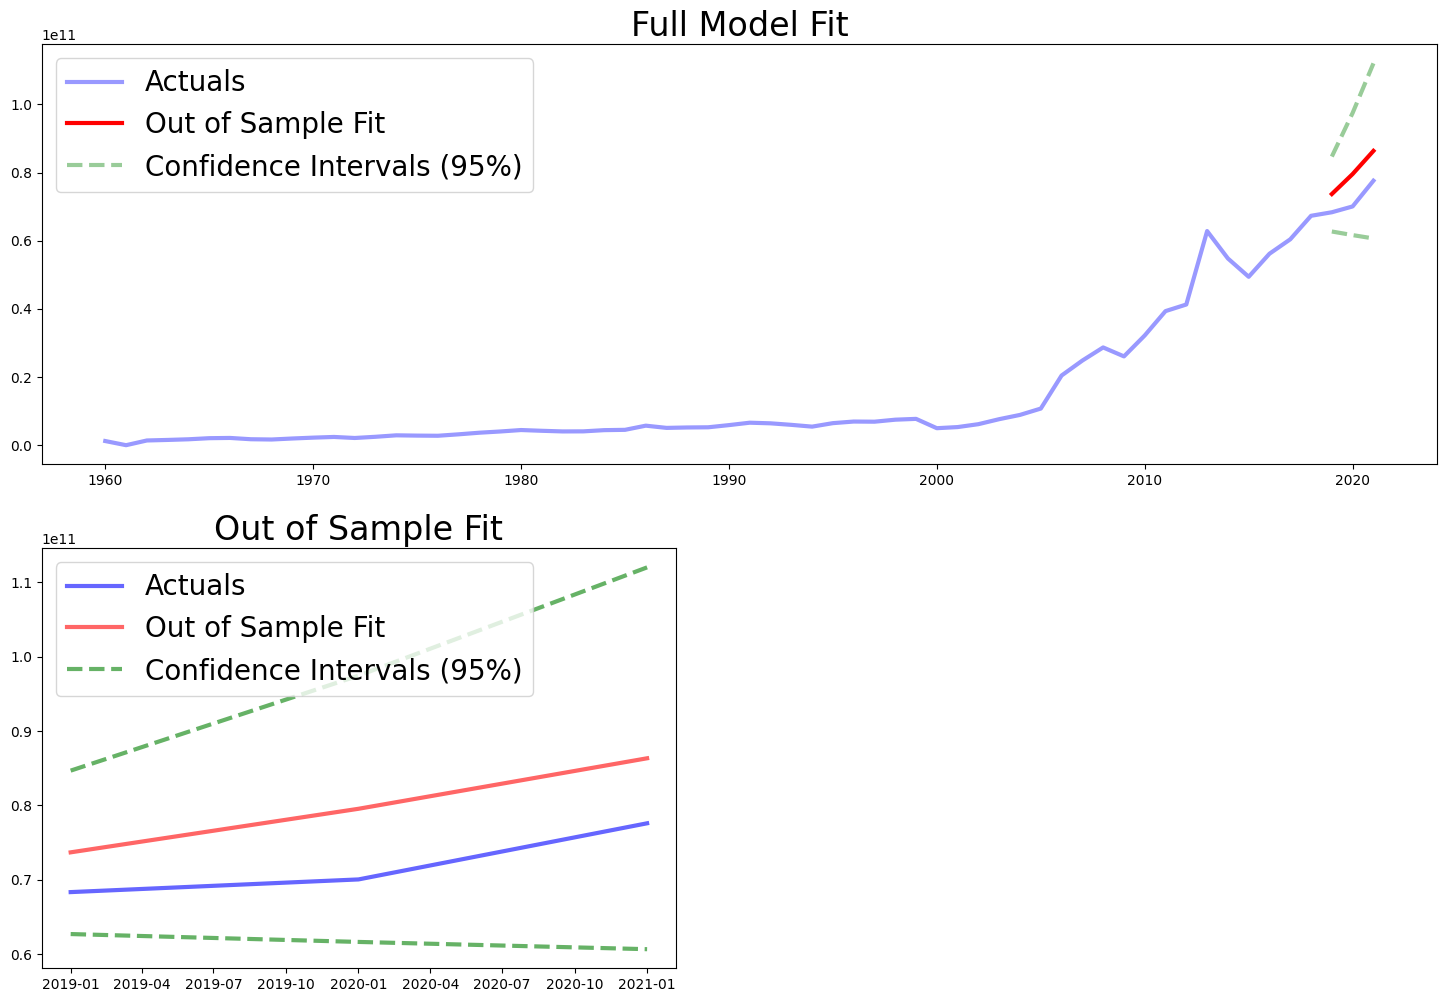

In [67]:
plt.rcParams["figure.figsize"] = 18, 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()



plt.show()

Предсказанный уровень GDP визуально продлевает предыдущую линию роста.